# Data
### Cleaned

In [1]:
import pandas as pd

df = pd.read_csv("df.csv")
df_cleaned = df[["StartTime", "Day-ahead Price [EUR/MWh]"]].rename(
    columns={"StartTime": "timestamp", "Day-ahead Price [EUR/MWh]": "price"}
)
df_cleaned.to_csv("df_cleaned.csv", index=False)
print("✅ df_cleaned.csv created successfully!")

✅ df_cleaned.csv created successfully!


### Parameter data concat and averaging

In [2]:
import pandas as pd
import glob

# Define parameters and their respective target columns
parameter_config = {
    "parameter_2": "Lufttemperatur",
    "parameter_5": "Nederbördsmängd",
    "parameter_8": "Snödjup",
    "parameter_10": "Solskenstid"
}
merged_data = pd.DataFrame()

for parameter, target_column in parameter_config.items():
    folder_path = f"/Users/iliemoromete/Desktop/ML-Project/ML-Project/data/smhi_data_2022-today/{parameter}/*.csv"
    csv_files = glob.glob(folder_path)
    dataframes = []

    for file in csv_files:
        try:
            df = pd.read_csv(file)
            df.columns = df.columns.str.strip()

            # Confirm required columns exist
            if "Datum" not in df.columns or target_column not in df.columns:
                print(f"❌ Skipping {file}: Missing required columns.")
                continue

            # Clean data
            df = df[["Datum", target_column]].copy()
            df["Datum"] = pd.to_datetime(df["Datum"], errors='coerce')
            df[target_column] = pd.to_numeric(df[target_column], errors='coerce')
            df = df.dropna()

            # Remove rows before 2014-01-01
            df = df[df["Datum"] >= "2014-01-01"]
            dataframes.append(df)
        except Exception as e:
            print(f"❌ Error reading {file}: {e}")

    # Combine and calculate mean
    if dataframes:
        df_combined = pd.concat(dataframes)
        df_result = df_combined.groupby("Datum").mean().reset_index()
        df_result.to_csv(f"{parameter}.csv", index=False)
        print(f"✅ '{parameter}.csv' has been successfully created!")

        # Merge with main dataframe
        if merged_data.empty:
            merged_data = df_result
        else:
            merged_data = pd.merge(merged_data, df_result, on="Datum", how="outer")
    else:
        print(f"❌ No valid data found in {parameter}.")
merged_data.sort_values("Datum", inplace=True)
merged_data.to_csv("parameter.csv", index=False)
print("✅ 'parameter.csv' has been successfully created!")

✅ 'parameter_2.csv' has been successfully created!
✅ 'parameter_5.csv' has been successfully created!
✅ 'parameter_8.csv' has been successfully created!
✅ 'parameter_10.csv' has been successfully created!
✅ 'parameter.csv' has been successfully created!


### Translate to a real language

In [3]:
import pandas as pd

# Load the existing parameter.csv file
df = pd.read_csv("parameter.csv")

# Translate headers
translation_map = {
    "Datum": "Date",
    "Lufttemperatur": "Air Temperature",
    "Nederbördsmängd": "Precipitation Amount",
    "Snödjup": "Snow Depth",
    "Solskenstid": "Sunshine Duration"
}
df.rename(columns=translation_map, inplace=True)
df.to_csv("parameter.csv", index=False)
print("✅ 'parameter.csv' headers have been successfully translated!")

✅ 'parameter.csv' headers have been successfully translated!


### Combine 'em all

In [4]:
import pandas as pd

df_cleaned = pd.read_csv("df_cleaned.csv", parse_dates=["timestamp"])
parameter = pd.read_csv("parameter.csv", parse_dates=["Date"])

parameter["Date"] = pd.to_datetime(parameter["Date"]).dt.date
df_cleaned["date"] = pd.to_datetime(df_cleaned["timestamp"]).dt.date
df_combined = pd.merge(df_cleaned, parameter, left_on="date", right_on="Date", how="left")
df_combined.drop(["date", "Date"], axis=1, inplace=True)
df_combined.to_csv("df_combined.csv", index=False)
print("✅ 'df_combined.csv' has been successfully created!")

✅ 'df_combined.csv' has been successfully created!


# Correlations

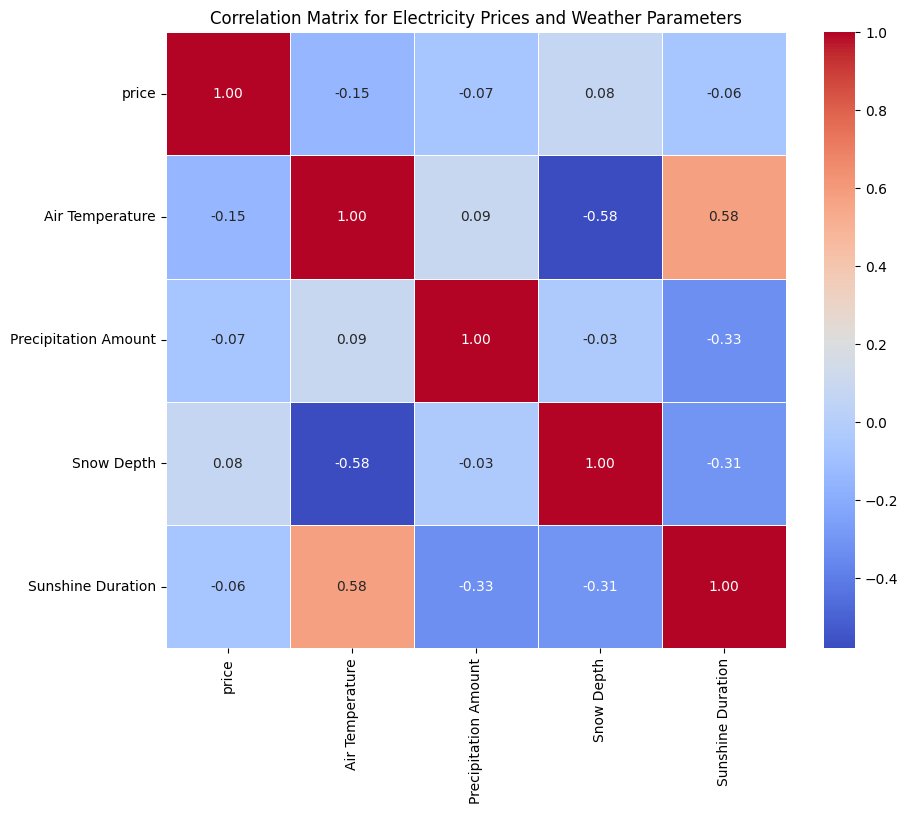

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("df_combined.csv", parse_dates=["timestamp"])
df.drop("timestamp", axis=1, inplace=True)
correlation_matrix = df.corr()

# Plot the correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix for Electricity Prices and Weather Parameters")
plt.show()


# Prediction

In [14]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from datetime import timedelta

# Load data
df = pd.read_csv("df_combined.csv", parse_dates=["timestamp"])
df.set_index("timestamp", inplace=True)
df = df[df.index >= "2022-01-01"]

# Feature Engineering
df['hour'] = df.index.hour
df['day_of_week'] = df.index.dayofweek
df['month'] = df.index.month

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# Sequence Creation Function
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])  # Predicting 'price'
    return np.array(X), np.array(y)

SEQ_LENGTH = 144  
X, y = create_sequences(scaled_data, SEQ_LENGTH)

# Split into train/test sets
split_idx = int(len(X) * 0.6)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Define the LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])),
    Dropout(0.3),
    LSTM(32, return_sequences=False),
    Dropout(0.3),
    Dense(10),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

# Predictions
predictions = model.predict(X_test)
predictions = predictions.reshape(-1, 1)

# Create padding with correct feature shape
padding = np.zeros((len(predictions), scaled_data.shape[1] - 1))
predictions_padded = np.concatenate((predictions, padding), axis=1)
predictions = scaler.inverse_transform(predictions_padded)[:, 0]

# Actual values
y_test = y_test.reshape(-1, 1)
padding_actual = np.zeros((len(y_test), scaled_data.shape[1] - 1))
y_test_padded = np.concatenate((y_test, padding_actual), axis=1)
y_test_actual = scaler.inverse_transform(y_test_padded)[:, 0]

Epoch 1/20


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


204/451 ━━━━━━━━━━━━━━━━━━━━ 10s 44ms/step - loss: 0.0144

KeyboardInterrupt: 

### Plotting results

Min actual price: -59.959999999999994
Percentage of near-zero values: 9.43%
📊 Evaluation Metrics:
✅ MAE: 10.52
✅ RMSE: 13.94
✅ MAPE by myself: 987462259306.99%
✅ MAPE by sklearn: 513632182789369.94%


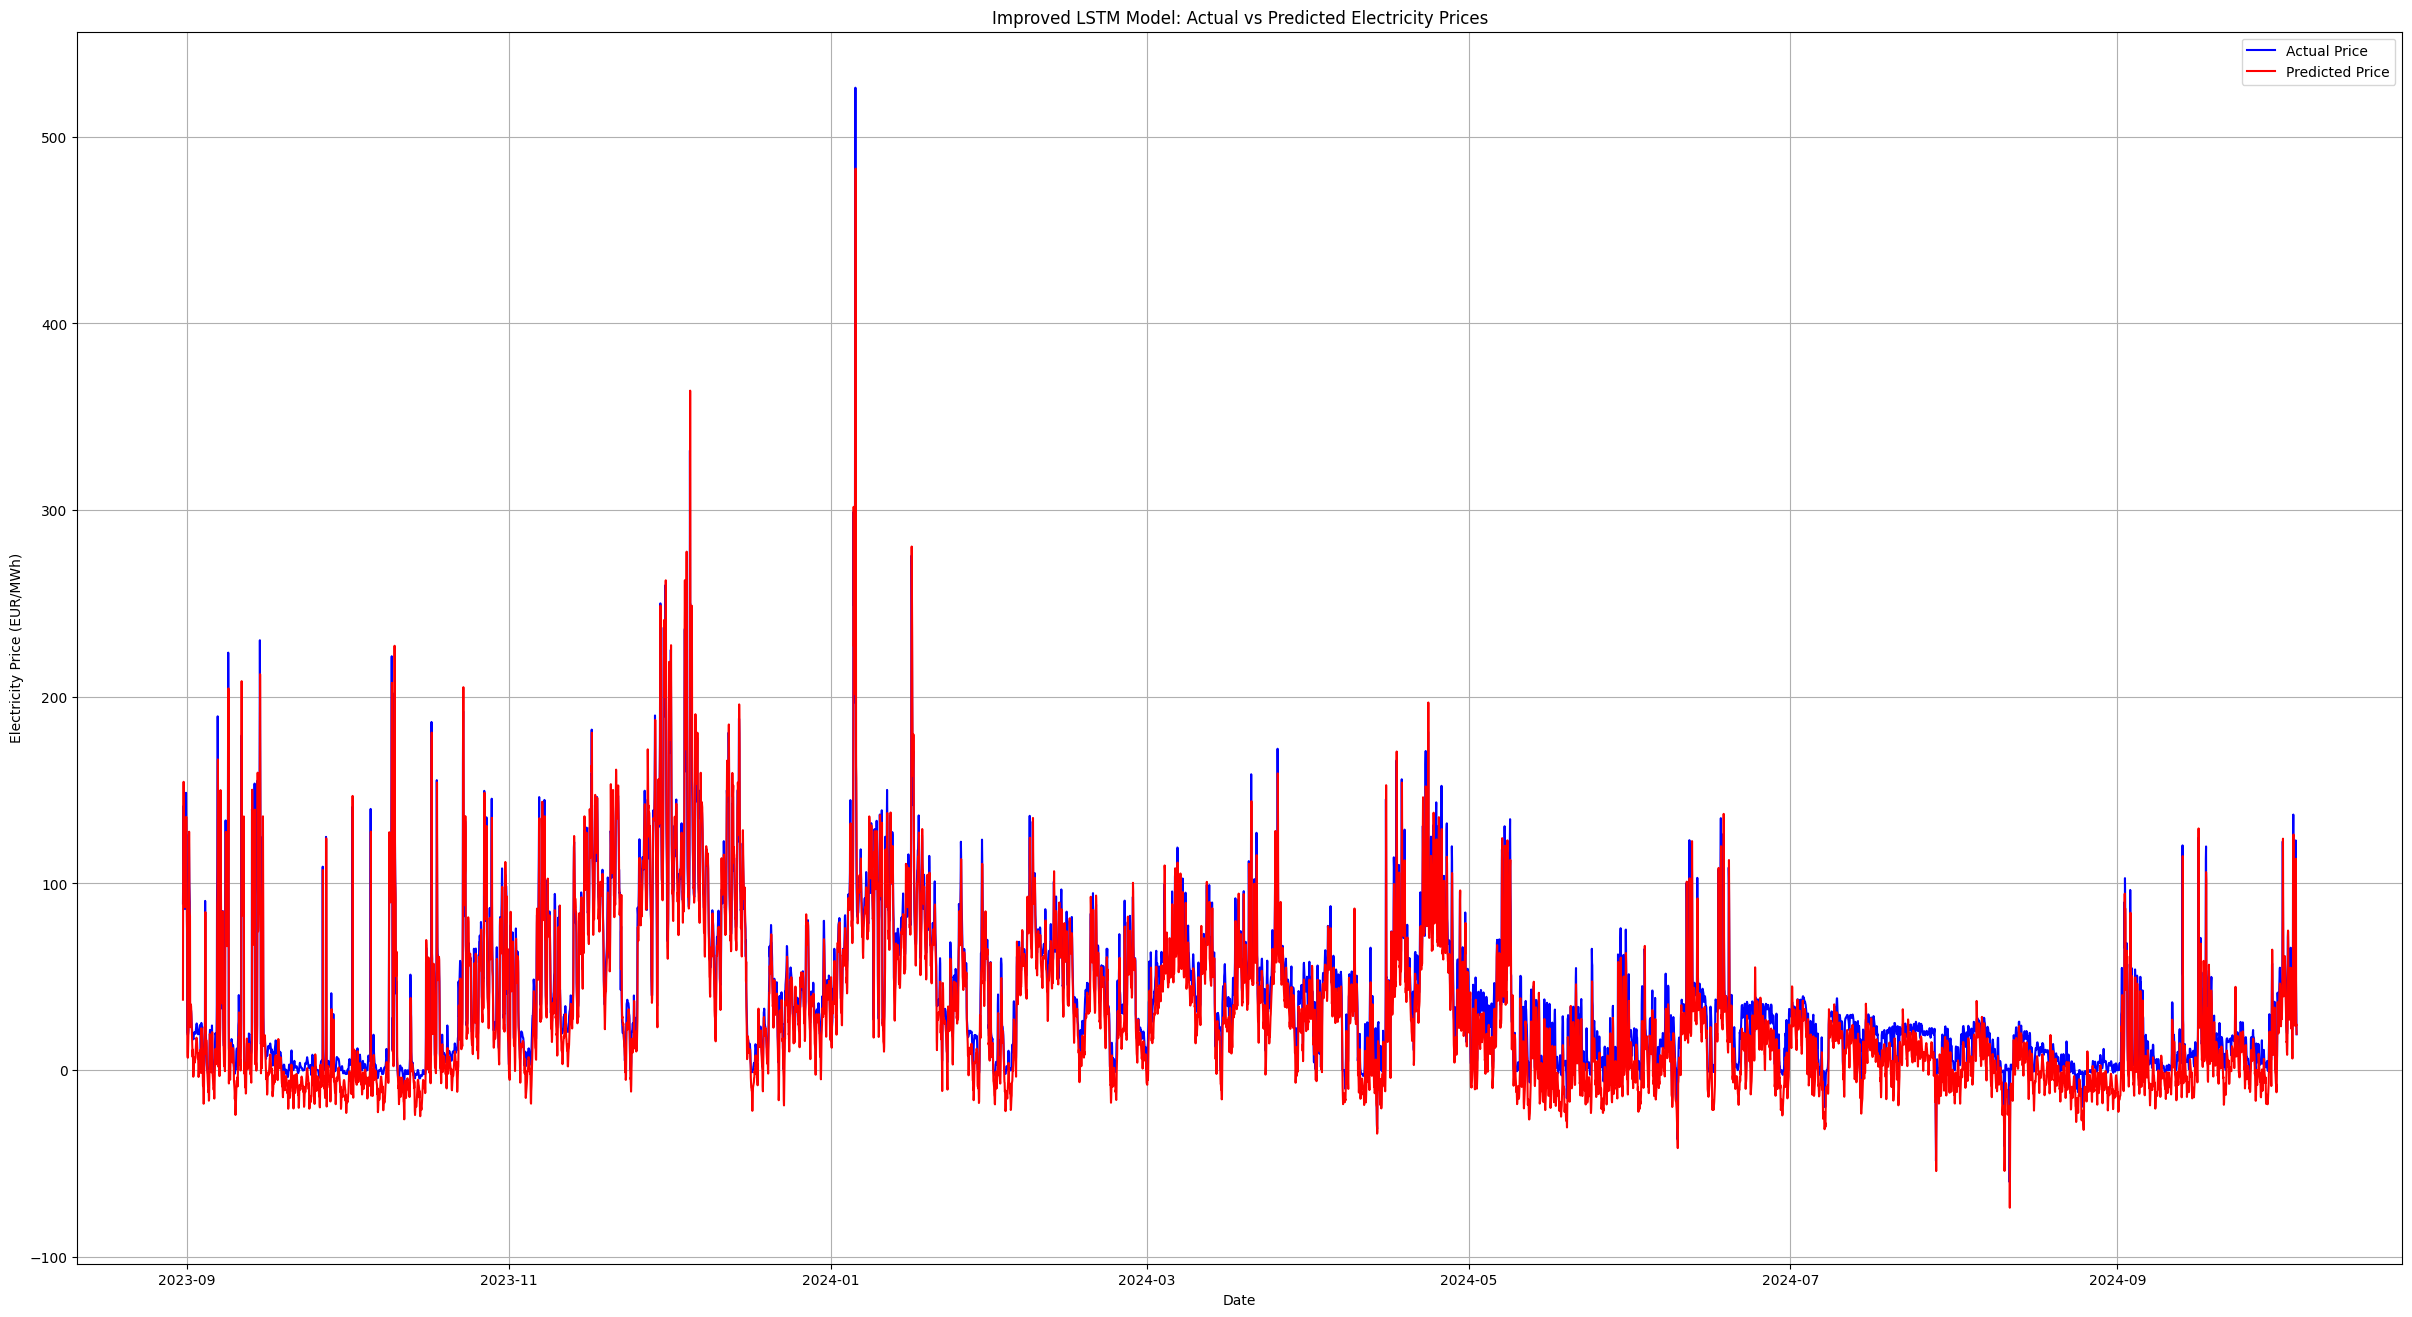

In [13]:
# Evaluation Metrics
epsilon = 1e-10  
mae = mean_absolute_error(y_test_actual, predictions)
rmse = np.sqrt(mean_squared_error(y_test_actual, predictions))
def safe_mape(actual, pred):
    return np.mean(np.abs((actual - pred) / np.maximum(actual, 1e-10))) * 100
mape = safe_mape(y_test_actual, predictions)
mape_sklearn = mean_absolute_percentage_error(y_test_actual, predictions)

print(f"Min actual price: {y_test_actual.min()}")
print(f"Percentage of near-zero values: {np.sum(y_test_actual < 0.1) / len(y_test_actual) * 100:.2f}%")
print(f"📊 Evaluation Metrics:")
print(f"✅ MAE: {mae:.2f}")
print(f"✅ RMSE: {rmse:.2f}")
print(f"✅ MAPE by myself: {mape:.2f}%")
print(f"✅ MAPE by sklearn: {mape_sklearn:.2f}%")

# Plotting
plt.figure(figsize=(30, 16))
plt.plot(df.index[-len(y_test):], y_test_actual, label='Actual Price', color='blue')
plt.plot(df.index[-len(y_test):], predictions, label='Predicted Price', color='red')
plt.xlabel("Date")
plt.ylabel("Electricity Price (EUR/MWh)")
plt.title("Improved LSTM Model: Actual vs Predicted Electricity Prices")
plt.legend()
plt.grid(True)
plt.show()